# Comparing PyProBE Performance

This example will demonstrate the performance benefits of PyProBE against Pandas, a popular library for dataframes.

In [1]:
import pyprobe
import pandas as pd
import timeit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Setting up data analysis in PyProBE requires conversion into the PyProBE format. This is normally the most time-intensive process, but only needs to be performed once.

In [2]:
info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}

cell = pyprobe.Cell(info =info_dictionary)
data_directory = '../../../tests/sample_data/neware'
# cell.process_cycler_file(cycler='neware',
#                         folder_path=data_directory,
#                         input_filename='sample_data_neware.xlsx',
#                         output_filename='sample_data_neware.parquet')

We will measure the time for PyProBE and Pandas to read from a parquet file and filter the data a few times. With PyProBE we can call the built-in filtering methods, whereas Pandas must perform the filtering manually.

In [3]:
def measure_pyprobe(repeats, file):
    steps = 5
    cumulative_time = np.zeros((steps,repeats))
    for repeat in range(repeats):
        start_time = timeit.default_timer()
        cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = file)
        cumulative_time[0, repeat] = timeit.default_timer() - start_time
        
        experiment = cell.procedure['Sample'].experiment('Break-in Cycles')
        cumulative_time[1, repeat] =timeit.default_timer() - start_time
        
        cycle = experiment.cycle(1)
        cumulative_time[2, repeat] =timeit.default_timer() - start_time
        
        step = cycle.discharge(0)
        cumulative_time[3, repeat] = timeit.default_timer() - start_time

        voltage = step.get("Voltage [V]")
        cumulative_time[4, repeat] = timeit.default_timer() - start_time
    
    return cumulative_time, voltage


def measure_pandas(repeats, file):
    steps = 6
    cumulative_time = np.zeros((steps,repeats))
    for repeat in range(repeats):
        start_time = timeit.default_timer()
        df = pd.read_csv(data_directory + '/' + str.replace(file, '.parquet', '.csv'))
        cumulative_time[0, repeat] = timeit.default_timer() - start_time

        start_time = timeit.default_timer()
        df = pd.read_parquet(data_directory + '/' + file)
        cumulative_time[1, repeat] = timeit.default_timer() - start_time

        experiment = df[df['Step'].isin([4, 5, 6, 7])]
        cumulative_time[2, repeat] = timeit.default_timer() - start_time

        unique_cycles = experiment['Cycle'].unique()
        
        cycle = experiment[experiment['Cycle'] == unique_cycles[1]]
        cumulative_time[3, repeat] =timeit.default_timer() - start_time
        
        step = cycle[cycle['Current [A]'] < 0]
        unique_events = step['Event'].unique()
        step = step[step['Event'] == unique_events[0]]
        cumulative_time[4, repeat] =timeit.default_timer() - start_time

        voltage = step['Voltage [V]'].values
        cumulative_time[5, repeat] = timeit.default_timer() - start_time
    
    return cumulative_time, voltage

def make_boxplots(total_time_polars, total_time_pandas):
    # Create labels for the boxplots
    labels = ["1: Read file", "2: Select experiment", "3: Select cycle", "4: Select step", "5: Return voltage"]
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Boxplot for Polars
    ax1.boxplot(total_time_polars.T, labels=labels, vert=True, patch_artist=True, showfliers=False)
    ax1.set_title('PyProBE Execution Time')
    ax1.set_ylabel('Cumulative Time (seconds)')

    # Boxplot for Pandas
    ax2.boxplot(total_time_pandas.T, labels=labels, vert=True, patch_artist=True, showfliers=False)
    ax2.set_title('Pandas Execution Time')
    ax2.yaxis.set_visible(False)  # Remove y-axis on the right-hand subplot

    # Adjust layout
    plt.tight_layout()
    plt.show()


Running the tests shows the initial overhead for PyProBE to read and filter the data is zero. This is because of the Lazy implementation where all the computation is delayed until the final request for data is made. Overall, it is faster than Pandas as the polars backend is able to optimize the filtering process, instead of requiring filters to be performed one-by-one.

/tmp/ipykernel_2157/3741776162.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(total_time_polars.T, labels=labels, vert=True, patch_artist=True, showfliers=False)
/tmp/ipykernel_2157/3741776162.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(total_time_pandas.T, labels=labels, vert=True, patch_artist=True, showfliers=False)


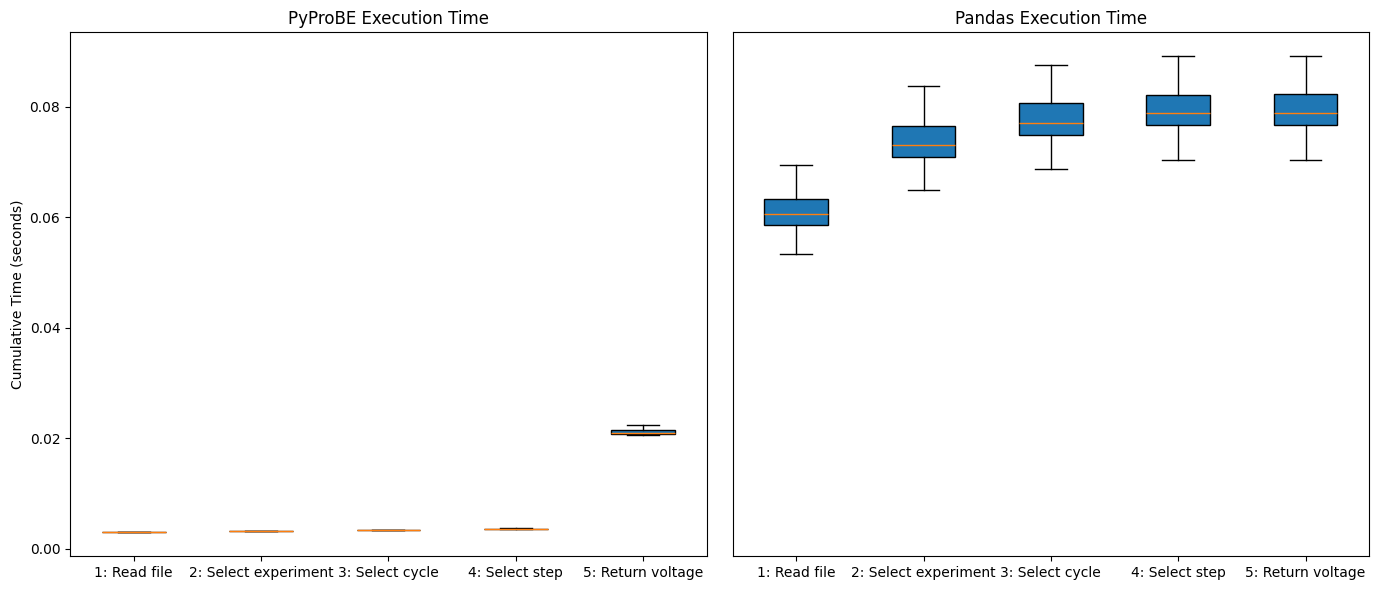

Pandas is on average 3.79 times slower than PyProBE at completion of the full query.


In [4]:
repeats = 100
total_time_polars, voltage_pyprobe = measure_pyprobe(repeats, 'sample_data_neware.parquet')
total_time_pandas, voltage_pandas = measure_pandas(repeats, 'sample_data_neware.parquet')
make_boxplots(total_time_polars, total_time_pandas[1:,:])
assert np.allclose(voltage_pyprobe, voltage_pandas)

average_final_difference = np.mean(total_time_pandas[-1,:])/np.mean(total_time_polars[-1,:])
print(f'Pandas is on average {average_final_difference:.2f} times slower than PyProBE at completion of the full query.')


Much of the performance behind PyProBE is careful selection of the data file format. PyProBE uses the .parquet file format due to its exceptional speed. The results above show pandas reading from the parquet format. The below plot illustrates its performance benefit:

/tmp/ipykernel_2157/3863093695.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(total_time_pandas[[0, 1],:].T, labels=['Read from .csv', 'Read from .parquet'], vert=True, patch_artist=True, showfliers=False)


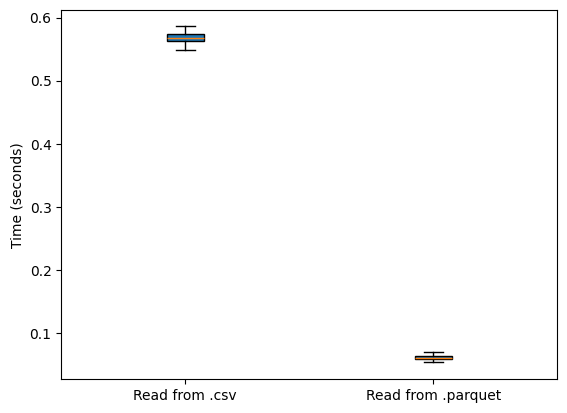

Reading from .parquet is on average 9.23 times faster than reading from .csv


In [5]:
plt.figure()
plt.boxplot(total_time_pandas[[0, 1],:].T, labels=['Read from .csv', 'Read from .parquet'], vert=True, patch_artist=True, showfliers=False)
plt.ylabel('Time (seconds)')
plt.show()

average_difference = np.mean(total_time_pandas[0,:])/np.mean(total_time_pandas[1,:])
print(f"Reading from .parquet is on average {average_difference:.2f} times faster than reading from .csv")

The Polars Lazy approach is best demonstrated by plotting the optimized graph:

In [6]:
lazyframe = cell.procedure['Sample'].experiment('Break-in Cycles').cycle(1).discharge(0).base_dataframe
print(lazyframe.explain(tree_format=True))

                          0                                               1                                         2                                3                                       4                                               5                                         6                                    7                                               8                                          9                                     10                                              11                                                                                                                        12
   ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/tmp/ipykernel_2157/938073181.py:2: DeprecationWarning: The `tree_format` parameter for `LazyFrame.explain` is deprecated Use the `format` parameter instead.
  print(lazyframe.explain(tree_format=True))
